# Conclusion
Int8 datatype overflow

# Questions
1. Why the two results are different, when applying my implementation of computing Gaussian gradient magnitude and scipy.ndimage.gaussian_gradient_magnitude()?
2. Why the two results are different, when applying scipy.ndimage.gaussian_gradient_magnitude() on scipy.misc.ascent image and scipy.datasets.ascent image? When the two images appears to remain the same in terms of shape, datatype and values.
3. When applying my implementation and scipy.ndimage.gaussian_gradient_magnitude() on scipy.misc.ascent image, the results are almost the same. When applying the two implementations on scipy.datasets.ascent image, the results are totally different. 
4. Which result should I trust?  

my scipy version is 1.10.1.



<class 'numpy.ndarray'>


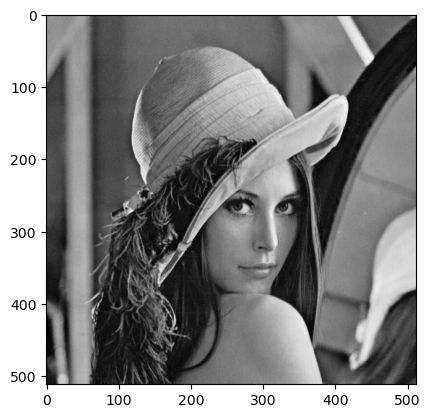

In [5]:
from scipy import ndimage, misc, datasets
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d.axes3d import get_test_data
import cv2 
gray_img = cv2.imread('lenna.jpg', 0)
print(type(gray_img))
plt.imshow(gray_img, cmap='gray')
sigma = 4

## 1. Why the two results are different, when applying my implementation of computing Gaussian gradient magnitude and scipy.ndimage.gaussian_gradient_magnitude()?

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int32'>
<class 'numpy.int64'>


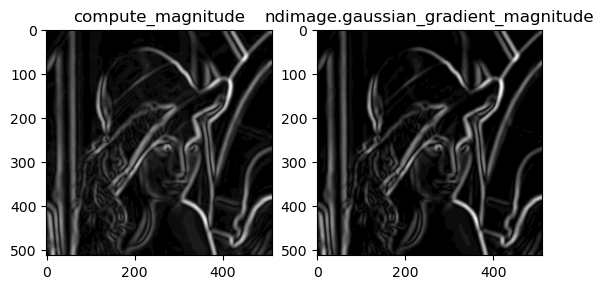

In [13]:
# My definition of Gaussian function and its partial derivatives
# https://hannibunny.github.io/orbook/preprocessing/04gaussianDerivatives.html
def gaussian_2d(x, y, sigma):
    return 1 / (2 * np.pi * sigma ** 2) * np.exp(-1 * (x*x + y*y) / (2 * sigma ** 2))
def x_partial_derivative_g2d(x, y, sigma):
    return -1 * x / (sigma ** 2) * gaussian_2d(x, y, sigma)
def y_partial_derivative_g2d(x, y, sigma):
    return -1 * y / (sigma ** 2) * gaussian_2d(x, y, sigma)

def compute_magnitude(image, sigma):
    # return gradient magnitude
    image = image.astype('int64')
    # Compute x-derivative 
    # https://hannibunny.github.io/orbook/preprocessing/04gaussianDerivatives.html
    x = np.arange(sigma * -3, sigma * 3 + 1, 1)
    y = x.copy()
    # np.meshgrid() generates mesh grid coordinates given x range and y range. Here we take the mesh grid as a kernel.  
    x, y = np.meshgrid(x, y) 
    x_derivative_kernel = x_partial_derivative_g2d(x, y, sigma)
    y_derivative_kernel = y_partial_derivative_g2d(x, y, sigma)
    # Filtering. OpenCV provides a function, cv2.filter2D(), to convolve a kernel with an image. 
    # The second parameter -1 indicates that the data type of the destination image remains as the data type as the source image.
    # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga27c049795ce870216ddfb366086b5a04
    print(type(image[0, 0]))
    x_edge = cv2.filter2D(image,-1, x_derivative_kernel)
    y_edge = cv2.filter2D(image,-1, y_derivative_kernel)
    print(type(y_edge[0, 0]))
    return np.sqrt(x_edge * x_edge + y_edge * y_edge) # Compute gradient magnitude


# experiment: comparing result of compute_magnitude(image, sigma) and ndimage.gaussian_gradient_magnitude(ascent, sigma)
def compareing_two_implementations(source_image, sigma):
    fig = plt.figure()
    plt.gray()  # show the filtered result in grayscale
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    source_image = source_image.astype('int64')
    # source_image = source_image / 255
    print(type(source_image[0, 0]))
    
    my_result = compute_magnitude(source_image, sigma)
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_gradient_magnitude.html#scipy.ndimage.gaussian_gradient_magnitude
    result = ndimage.gaussian_gradient_magnitude(source_image, sigma=sigma)
    print(type(result[0, 0]))
    ax1.imshow(my_result)
    ax1.set_title('compute_magnitude')
    ax2.imshow(result)
    ax2.set_title('ndimage.gaussian_gradient_magnitude')
    plt.show()

compareing_two_implementations(gray_img, sigma)

## 2. Why the two results are different, when applying scipy.ndimage.gaussian_gradient_magnitude() on scipy.misc.ascent image and scipy.datasets.ascent image? When the two images appears to remain the same in terms of shape, datatype and values.

/tmp/ipykernel_4391/175504809.py:17: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  misc_ascent = misc.ascent()


<class 'numpy.int64'>
<class 'numpy.uint8'>


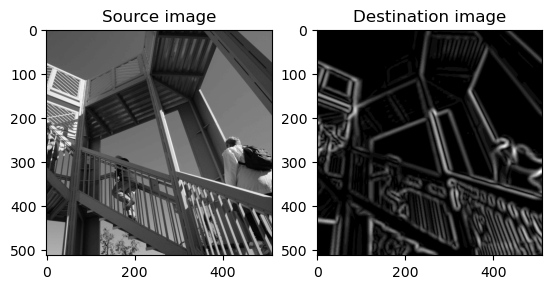

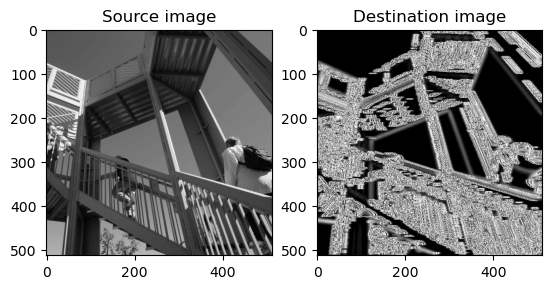

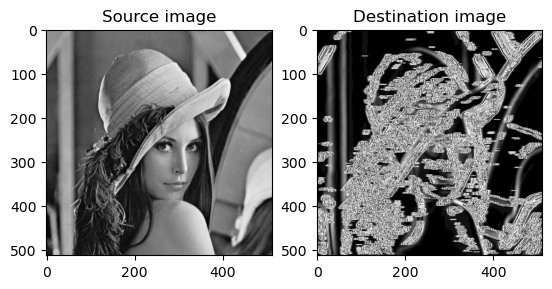

In [7]:
from scipy import ndimage, misc, datasets
import matplotlib.pyplot as plt
def gaussian_gradient_magnitude(image, sigma):
    fig = plt.figure()
    plt.gray()  # show the filtered result in grayscale
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    result = ndimage.gaussian_gradient_magnitude(image, sigma=sigma)
    ax1.imshow(image)
    ax1.set_title('Source image')
    ax2.imshow(result)
    ax2.set_title('Destination image')
    plt.show()

# Experiment 2: Showing the difference between scipy.misc and scipy.datasets
# https://docs.scipy.org/doc/scipy-1.0.0/reference/generated/scipy.ndimage.gaussian_gradient_magnitude.html
misc_ascent = misc.ascent()
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_gradient_magnitude.html#scipy.ndimage.gaussian_gradient_magnitude
datasets_ascent = datasets.ascent()
print(type(misc_ascent[0, 0])) # <class 'numpy.int64'>
print(type(datasets_ascent[0, 0])) # <class 'numpy.uint8'>
#####===================验证了问题的原因。两张图片的值确实是一样的。但是两张图片的元素的数据类型不一样。所以int64的没有溢出，而int8的溢出了。所以看起来是糊的================


# using scipy.misc dataset
gaussian_gradient_magnitude(misc_ascent, sigma=sigma)
# # using scipy.datasets dataset
gaussian_gradient_magnitude(datasets_ascent, sigma=sigma)
# It seems the two source images are the same, but the results are different. 
# These two experiments suggest that the source images might be different.


# apply it to our image. This seems to prove that my implementation is wrong. Nevertheless, Let's see next experiment.
gaussian_gradient_magnitude(gray_img, sigma=sigma)



In [8]:
# check source images' shape, type and value
print('type of misc_ascent:', type(misc_ascent))
print('type of datasets_ascent:', type(datasets_ascent))
print('shape of misc_ascent:', misc_ascent.shape)
print('shape of datasets_ascent:', datasets_ascent.shape)
ascent_diff = misc_ascent - datasets_ascent
print('difference between misc_ascent and datasets_ascent', np.sum(np.abs(ascent_diff)))
# This experiment suggests that the source images are the same.

type of misc_ascent: <class 'numpy.ndarray'>
type of datasets_ascent: <class 'numpy.ndarray'>
shape of misc_ascent: (512, 512)
shape of datasets_ascent: (512, 512)
difference between misc_ascent and datasets_ascent 0


## 3. When applying my implementation and scipy.ndimage.gaussian_gradient_magnitude() on scipy.misc.ascent image, the results are almost the same. When applying the two implementations on scipy.datasets.ascent image, the results are totally different. 

<class 'numpy.int64'>
<class 'numpy.int32'>
<class 'numpy.int64'>


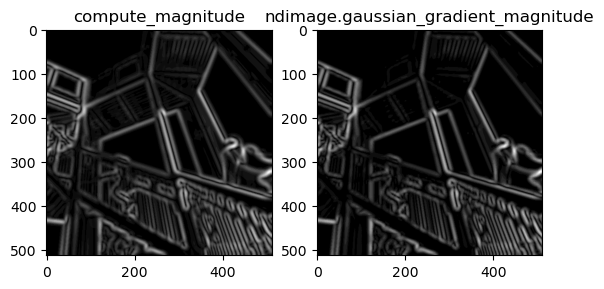

<class 'numpy.int64'>
<class 'numpy.int32'>
<class 'numpy.int64'>


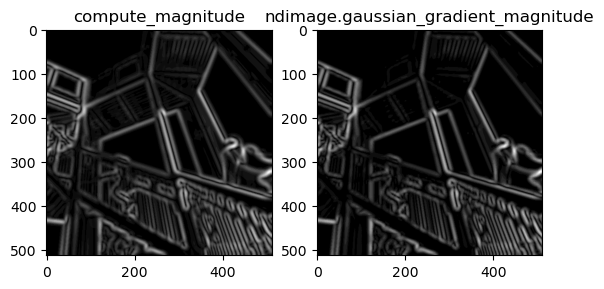

In [9]:
# comparing two implementations on scipy.misc dataset
compareing_two_implementations(misc_ascent, sigma)
# This result shows that the two implementations are almost the same. 
# And this result may suggest that my implementation is correct.


# comparing two implementations on scipy.datasets dataset
compareing_two_implementations(datasets_ascent, sigma)
# This result shows that the two implementations are totally different. 
# But this result may suggest that my implementation is incorrect.


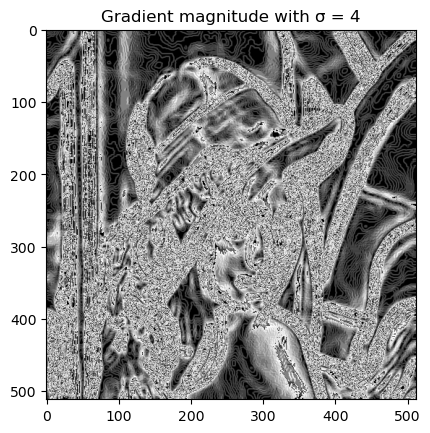

In [10]:
# from Bard
import numpy as np
from scipy import ndimage

def gradient_magnitude(image, sigma):
    """
    Calculates the gradient magnitude of an image using Gaussian derivatives.
    Args:
        image: The input image.
        sigma: The standard deviation of the Gaussian derivative filter.
    Returns:
        The gradient magnitude of the image.
    """

    # Convert the image to grayscale if it is not already grayscale.
    if len(image.shape) == 3:
        image = np.mean(image, axis=2)
    # Calculate the x and y derivatives of the image.
    magnitude = ndimage.gaussian_filter(image, sigma)
    dx = ndimage.sobel(magnitude, axis=1)
    dy = ndimage.sobel(magnitude, axis=0)
    # Calculate the magnitude of the derivatives.
    magnitude = np.sqrt(dx**2 + dy**2)
    # magnitude = magnitude.astype('i')
    # Apply a Gaussian blur to the magnitude image.
    return magnitude

# Calculate the gradient magnitude for different values of sigma.
magnitudes = []
for sigma in [4]:
    magnitude = gradient_magnitude(gray_img, sigma)
    plt.imshow(magnitude, cmap='gray')
    plt.title(f'Gradient magnitude with σ = {sigma}')
    plt.show()
